In [ ]:
# =============================================================================
# PART 1: SETUP & DATA COLLECTION (30 minutes)
# =============================================================================

# Install dependencies
!pip install rdkit-pypi torch-geometric chembl-webresource-client "numpy<2" -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from chembl_webresource_client.new_client import new_client
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("🔧 Environment setup complete!")

🔧 Environment setup complete!


In [ ]:
# =============================================================================
# SIMPLIFIED DATA COLLECTION
# =============================================================================

def collect_sample_data():
    """Collect a small dataset for demonstration"""

    # Define a small set of important drug targets
    target_chembl_ids = [
        'CHEMBL279',    # CYP3A4
        'CHEMBL2095192', # CYP2D6
        'CHEMBL240',    # Acetylcholinesterase
        'CHEMBL220',    # Adenosine A1 receptor
        'CHEMBL251',    # Dopamine D2 receptor
        'CHEMBL233',    # Histamine H1 receptor
        'CHEMBL254',    # Serotonin 5-HT2A receptor
        'CHEMBL228',    # Muscarinic M1 receptor
    ]

    print("📊 Collecting bioactivity data...")

    # Collect activities for each target
    activities_data = []
    activity_client = new_client.activity

    for target_id in tqdm(target_chembl_ids[:5]):  # Limit to 5 targets for speed
        try:
            activities = activity_client.filter(
                target_chembl_id=target_id,
                standard_type__in=['IC50', 'Ki', 'Kd'],
                standard_relation='=',
                pchembl_value__isnull=False
            ).only(['molecule_chembl_id', 'standard_value', 'pchembl_value', 'canonical_smiles'])

            for activity in activities[:200]:  # Limit compounds per target
                if activity['canonical_smiles']:
                    activities_data.append({
                        'compound_id': activity['molecule_chembl_id'],
                        'target_id': target_id,
                        'smiles': activity['canonical_smiles'],
                        'pchembl_value': activity['pchembl_value'],
                        'active': 1 if float(activity['pchembl_value'] or 0) >= 6.0 else 0
                    })
        except Exception as e:
            print(f"Error with target {target_id}: {e}")
            continue

    df = pd.DataFrame(activities_data)
    print(f"✅ Collected {len(df)} bioactivity records")
    return df

# Collect data
bioactivity_df = collect_sample_data()
print(f"📈 Dataset shape: {bioactivity_df.shape}")
print(bioactivity_df.head())

📊 Collecting bioactivity data...


100%|██████████| 5/5 [00:23<00:00,  4.76s/it]

✅ Collected 868 bioactivity records
📈 Dataset shape: (868, 5)
    compound_id  target_id                                             smiles  \
0   CHEMBL68920  CHEMBL279  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1   CHEMBL69638  CHEMBL279        Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1   
2  CHEMBL419526  CHEMBL279                      c1ccc(-c2cnc(Nc3ccccn3)o2)cc1   
3  CHEMBL443268  CHEMBL279  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...   
4  CHEMBL330621  CHEMBL279                     Cc1ccc(Nc2ncc(-c3ccccc3)s2)nc1   

  pchembl_value  active  
0          4.78       0  
1          5.15       0  
2          5.73       0  
3          5.00       0  
4          7.72       1  


In [ ]:
# =============================================================================
# SIMPLIFIED DATA COLLECTION (10 TARGETS)
# =============================================================================

from chembl_webresource_client.new_client import new_client
from tqdm import tqdm
import pandas as pd


def collect_sample_data_10_targets():
    """Collect a small dataset for demonstration with 10 targets"""

    # Define a small set of important drug targets
    target_chembl_ids = [
        'CHEMBL279',    # CYP3A4
        'CHEMBL2095192', # CYP2D6
        'CHEMBL240',    # Acetylcholinesterase
        'CHEMBL220',    # Adenosine A1 receptor
        'CHEMBL251',    # Dopamine D2 receptor
        'CHEMBL233',    # Histamine H1 receptor
        'CHEMBL254',    # Serotonin 5-HT2A receptor
        'CHEMBL228',    # Muscarinic M1 receptor
        'CHEMBL4600',   # BACE1
        'CHEMBL4822',   # CDK2
    ]

    print("📊 Collecting bioactivity data...")

    # Collect activities for each target
    activities_data = []
    activity_client = new_client.activity

    for target_id in tqdm(target_chembl_ids[:10]):  # Limit to 10 targets
        try:
            activities = activity_client.filter(
                target_chembl_id=target_id,
                standard_type__in=['IC50', 'Ki', 'Kd'],
                standard_relation='=',
                pchembl_value__isnull=False
            ).only(['molecule_chembl_id', 'standard_value', 'pchembl_value', 'canonical_smiles'])

            for activity in activities[:200]:  # Limit compounds per target
                if activity['canonical_smiles']:
                    activities_data.append({
                        'compound_id': activity['molecule_chembl_id'],
                        'target_id': target_id,
                        'smiles': activity['canonical_smiles'],
                        'pchembl_value': activity['pchembl_value'],
                        'active': 1 if float(activity['pchembl_value'] or 0) >= 6.0 else 0
                    })
        except Exception as e:
            print(f"Error with target {target_id}: {e}")
            continue

    df = pd.DataFrame(activities_data)
    print(f"✅ Collected {len(df)} bioactivity records")
    return df

# Collect data with 10 targets
bioactivity_df = collect_sample_data_10_targets()
print(f"📈 Dataset shape: {bioactivity_df.shape}")
print(bioactivity_df.head())

📊 Collecting bioactivity data...


100%|██████████| 10/10 [00:31<00:00,  3.17s/it]

✅ Collected 1868 bioactivity records
📈 Dataset shape: (1868, 5)
    compound_id  target_id                                             smiles  \
0   CHEMBL68920  CHEMBL279  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   
1   CHEMBL69638  CHEMBL279        Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1   
2  CHEMBL419526  CHEMBL279                      c1ccc(-c2cnc(Nc3ccccn3)o2)cc1   
3  CHEMBL443268  CHEMBL279  Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...   
4  CHEMBL330621  CHEMBL279                     Cc1ccc(Nc2ncc(-c3ccccc3)s2)nc1   

  pchembl_value  active  
0          4.78       0  
1          5.15       0  
2          5.73       0  
3          5.00       0  
4          7.72       1  


In [ ]:
# =============================================================================
# PART 2: MOLECULAR GRAPH CONSTRUCTION (20 minutes)
# =============================================================================

class SimpleMolecularGraphBuilder:
    """Lightweight molecular graph builder for Colab"""

    def __init__(self):
        self.atom_features_dim = 7
        self.bond_features_dim = 3

    def smiles_to_graph(self, smiles):
        """Convert SMILES to PyTorch Geometric graph"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Node features (atoms)
        atom_features = []
        for atom in mol.GetAtoms():
            features = [
                atom.GetAtomicNum(),
                atom.GetDegree(),
                atom.GetFormalCharge(),
                int(atom.GetHybridization()),
                int(atom.GetIsAromatic()),
                int(atom.IsInRing()),
                atom.GetTotalNumHs()
            ]
            atom_features.append(features)

        # Edge indices and features (bonds)
        edge_indices = []
        edge_features = []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            edge_indices.extend([[start, end], [end, start]])  # Undirected

            bond_feature = [
                bond.GetBondTypeAsDouble(),
                int(bond.GetIsConjugated()),
                int(bond.IsInRing())
            ]
            edge_features.extend([bond_feature, bond_feature])

        # Convert to tensors
        x = torch.tensor(atom_features, dtype=torch.float)
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_features, dtype=torch.float)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)

# Build molecular graphs
print("🔗 Building molecular graphs...")
graph_builder = SimpleMolecularGraphBuilder()

# Process unique compounds
unique_compounds = bioactivity_df[['compound_id', 'smiles']].drop_duplicates()
print(f"Processing {len(unique_compounds)} unique compounds...")

molecular_graphs = {}
failed_count = 0

for idx, row in tqdm(unique_compounds.iterrows(), total=len(unique_compounds)):
    graph = graph_builder.smiles_to_graph(row['smiles'])
    if graph is not None:
        molecular_graphs[row['compound_id']] = graph
    else:
        failed_count += 1

print(f"✅ Successfully processed {len(molecular_graphs)} compounds")
print(f"❌ Failed to process {failed_count} compounds")

🔗 Building molecular graphs...
Processing 1583 unique compounds...


100%|██████████| 1583/1583 [00:02<00:00, 741.78it/s]

✅ Successfully processed 1583 compounds
❌ Failed to process 0 compounds


🎯 Preparing self-supervised learning...
Using 1583 graphs for pre-training
🚀 Training on cpu
Starting self-supervised pre-training...


  7%|▋         | 1/15 [00:00<00:12,  1.16it/s]

Epoch 0: SSL Loss = 2.0687


 40%|████      | 6/15 [00:05<00:08,  1.10it/s]

Epoch 5: SSL Loss = 0.7556


 73%|███████▎  | 11/15 [00:08<00:03,  1.33it/s]

Epoch 10: SSL Loss = 0.7082


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]

✅ Self-supervised pre-training complete!


Text(0, 0.5, 'Loss')

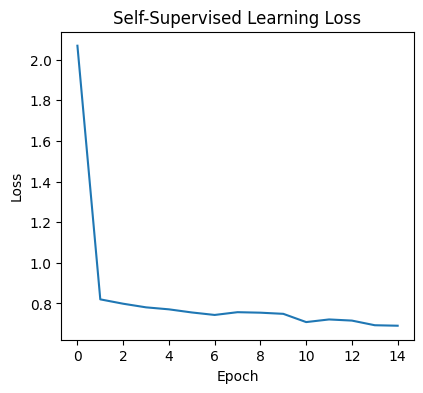

In [ ]:
# =============================================================================
# PART 3: SELF-SUPERVISED PRE-TRAINING (45 minutes)
# =============================================================================

class SimpleGNN(nn.Module):
    """Lightweight GNN for Colab"""

    def __init__(self, input_dim=7, hidden_dim=64, num_layers=3):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        # Input layer
        self.convs.append(GCNConv(input_dim, hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.dropout = nn.Dropout(0.2)

    def forward(self, x, edge_index, batch=None):
        # Node embeddings
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = self.dropout(x)

        # Graph-level embedding
        if batch is not None:
            x = global_mean_pool(x, batch)

        return x

class NodeMaskingSSL(nn.Module):
    """Simple node masking for self-supervised learning"""

    def __init__(self, encoder, hidden_dim=64, mask_rate=0.15):
        super().__init__()
        self.encoder = encoder
        self.mask_rate = mask_rate
        self.mask_token = nn.Parameter(torch.randn(7))  # Same as input dim
        self.decoder = nn.Linear(hidden_dim, 119)  # Predict atomic number

    def forward(self, data):
        # Create random mask
        num_nodes = data.x.size(0)
        mask = torch.rand(num_nodes) < self.mask_rate

        # Store original and apply mask
        original_x = data.x.clone()
        data.x[mask] = self.mask_token

        # Encode
        node_embeddings = self.encoder(data.x, data.edge_index)

        # Decode masked nodes
        if mask.sum() > 0:
            masked_embeddings = node_embeddings[mask]
            predictions = self.decoder(masked_embeddings)
            targets = original_x[mask, 0].long()  # Atomic number
            loss = F.cross_entropy(predictions, targets)
        else:
            loss = torch.tensor(0.0, requires_grad=True)

        return loss, node_embeddings

# Prepare data for pre-training
print("🎯 Preparing self-supervised learning...")

# Convert graphs to list for DataLoader
graph_list = list(molecular_graphs.values())
print(f"Using {len(graph_list)} graphs for pre-training")

# Create DataLoader
ssl_loader = DataLoader(graph_list, batch_size=32, shuffle=True)

# Initialize SSL model
encoder = SimpleGNN(input_dim=7, hidden_dim=64)
ssl_model = NodeMaskingSSL(encoder)

# Training setup
optimizer = torch.optim.Adam(ssl_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ssl_model.to(device)

print(f"🚀 Training on {device}")

# Self-supervised pre-training
ssl_losses = []
num_epochs = 15  # Reduced for Colab

print("Starting self-supervised pre-training...")
ssl_model.train()

for epoch in tqdm(range(num_epochs)):
    epoch_losses = []

    for batch in ssl_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        loss, _ = ssl_model(batch)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    avg_loss = np.mean(epoch_losses)
    ssl_losses.append(avg_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: SSL Loss = {avg_loss:.4f}")

print("✅ Self-supervised pre-training complete!")

# Visualize training
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ssl_losses)
plt.title('Self-Supervised Learning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [ ]:
# =============================================================================
# PART 4: MULTI-TARGET FINE-TUNING (30 minutes)
# =============================================================================

class MultiTargetPredictor(nn.Module):
    """Simple multi-target predictor"""

    def __init__(self, encoder, hidden_dim=64, num_targets=5):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_targets),
            nn.Sigmoid()
        )

    def forward(self, x, edge_index, batch):
        # Get graph embeddings
        embeddings = self.encoder(x, edge_index, batch)
        # Predict for all targets
        predictions = self.classifier(embeddings)
        return predictions

# Prepare multi-target dataset
print("📊 Preparing multi-target dataset...")

# Create compound-target matrix
pivot_df = bioactivity_df.pivot_table(
    index='compound_id',
    columns='target_id',
    values='active',
    fill_value=0
)

print(f"Multi-target matrix shape: {pivot_df.shape}")

# Filter compounds that have graphs
available_compounds = list(set(pivot_df.index) & set(molecular_graphs.keys()))
pivot_df = pivot_df.loc[available_compounds]

print(f"Final dataset: {len(available_compounds)} compounds × {pivot_df.shape[1]} targets")

# Prepare data for training
X_graphs = [molecular_graphs[cid] for cid in pivot_df.index]
# Cast y_targets to long to ensure binary format for metrics
y_targets = torch.tensor(pivot_df.values, dtype=torch.long)

# Train/test split
train_graphs, test_graphs, y_train, y_test = train_test_split(
    X_graphs, y_targets, test_size=0.2, random_state=42
)

# Create DataLoaders
train_data = list(zip(train_graphs, y_train))
test_data = list(zip(test_graphs, y_test))

from torch_geometric.data import Batch

def collate_fn(batch):
    graphs, labels = zip(*batch)
    # Manually create batched graph and stack labels
    batch_graphs = Batch.from_data_list(graphs)
    batch_labels = torch.stack(labels)
    return batch_graphs, batch_labels

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Initialize multi-target model
mt_model = MultiTargetPredictor(
    encoder=ssl_model.encoder,  # Use pre-trained encoder
    hidden_dim=64,
    num_targets=pivot_df.shape[1]
)
mt_model.to(device)

# Fine-tuning setup
mt_optimizer = torch.optim.Adam(mt_model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

print("🎯 Starting multi-target fine-tuning...")

# Fine-tuning loop
mt_losses = []
num_epochs = 20

mt_model.train()
for epoch in tqdm(range(num_epochs)):
    epoch_losses = []

    for batch_graphs, batch_labels in train_loader:
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.to(device)

        mt_optimizer.zero_grad()

        predictions = mt_model(
            batch_graphs.x,
            batch_graphs.edge_index,
            batch_graphs.batch
        )

        # Ensure batch_labels is float for BCELoss
        loss = criterion(predictions, batch_labels.float())
        loss.backward()
        mt_optimizer.step()

        epoch_losses.append(loss.item())

    avg_loss = np.mean(epoch_losses)
    mt_losses.append(avg_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Multi-target Loss = {avg_loss:.4f}")

print("✅ Multi-target fine-tuning complete!")

📊 Preparing multi-target dataset...
Multi-target matrix shape: (1583, 10)
Final dataset: 1583 compounds × 10 targets
🎯 Starting multi-target fine-tuning...


  5%|▌         | 1/20 [00:01<00:20,  1.05s/it]

Epoch 0: Multi-target Loss = 0.4348


 30%|███       | 6/20 [00:05<00:11,  1.17it/s]

Epoch 5: Multi-target Loss = 0.2458


 55%|█████▌    | 11/20 [00:09<00:07,  1.22it/s]

Epoch 10: Multi-target Loss = 0.2240


 80%|████████  | 16/20 [00:14<00:03,  1.04it/s]

Epoch 15: Multi-target Loss = 0.2143


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]

✅ Multi-target fine-tuning complete!


📈 Evaluating model performance...
🎯 RESULTS SUMMARY
CHEMBL2095192: AUC=0.808, AP=0.102
CHEMBL220: AUC=0.503, AP=0.078
CHEMBL228: AUC=0.704, AP=0.125
CHEMBL233: AUC=0.866, AP=0.375
CHEMBL240: AUC=0.729, AP=0.095
CHEMBL251: AUC=0.690, AP=0.119
CHEMBL254: AUC=0.735, AP=0.147
CHEMBL279: AUC=0.786, AP=0.353
CHEMBL4600: AUC=0.716, AP=0.075
CHEMBL4822: AUC=0.926, AP=0.407

Average AUC: 0.746
Average AP: 0.188


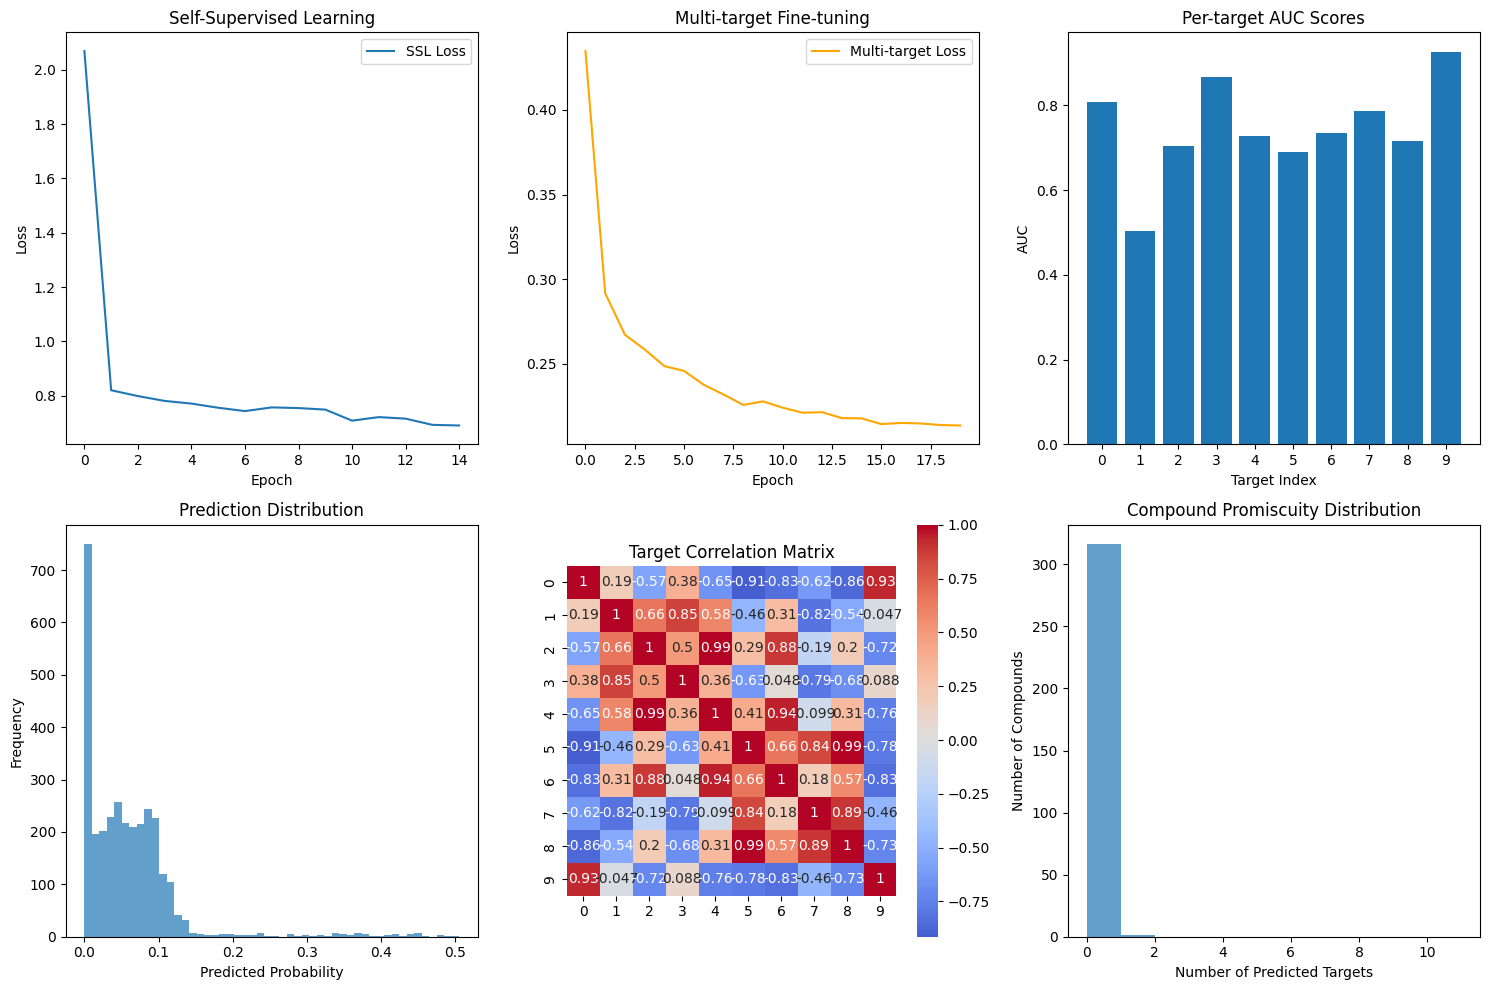


🎉 ANALYSIS COMPLETE!
✅ Processed 1583 compounds
✅ Trained on 10 targets
✅ Average performance: AUC=0.746

🔬 This demonstrates the core concepts of self-supervised graph learning
   for polypharmacology prediction in a Colab-friendly format!


In [ ]:
# =============================================================================
# PART 5: EVALUATION & VISUALIZATION (15 minutes)
# =============================================================================

print("📈 Evaluating model performance...")

# Evaluation
mt_model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_graphs, batch_labels in test_loader:
        batch_graphs = batch_graphs.to(device)
        predictions = mt_model(
            batch_graphs.x,
            batch_graphs.edge_index,
            batch_graphs.batch
        )
        all_predictions.append(predictions.cpu())
        all_targets.append(batch_labels)

# Concatenate results
y_pred = torch.cat(all_predictions, dim=0).numpy()
y_true = torch.cat(all_targets, dim=0).numpy()

# Calculate metrics
target_names = pivot_df.columns.tolist()
results = {}

for i, target in enumerate(target_names):
    if y_true[:, i].sum() > 0:  # Only if we have positive samples
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        ap = average_precision_score(y_true[:, i], y_pred[:, i])
        results[target] = {'AUC': auc, 'AP': ap}

# Display results
print("🎯 RESULTS SUMMARY")
print("=" * 50)
for target, metrics in results.items():
    print(f"{target}: AUC={metrics['AUC']:.3f}, AP={metrics['AP']:.3f}")

avg_auc = np.mean([m['AUC'] for m in results.values()])
avg_ap = np.mean([m['AP'] for m in results.values()])
print(f"\nAverage AUC: {avg_auc:.3f}")
print(f"Average AP: {avg_ap:.3f}")

# Visualizations
plt.figure(figsize=(15, 10))

# Training losses
plt.subplot(2, 3, 1)
plt.plot(ssl_losses, label='SSL Loss')
plt.title('Self-Supervised Learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(mt_losses, label='Multi-target Loss', color='orange')
plt.title('Multi-target Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Performance metrics
plt.subplot(2, 3, 3)
aucs = [results[t]['AUC'] for t in results.keys()]
plt.bar(range(len(aucs)), aucs)
plt.title('Per-target AUC Scores')
plt.xlabel('Target Index')
plt.ylabel('AUC')
plt.xticks(range(len(aucs)), range(len(aucs)))

# Prediction distribution
plt.subplot(2, 3, 4)
plt.hist(y_pred.flatten(), bins=50, alpha=0.7, label='Predictions')
plt.title('Prediction Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

# Target correlation heatmap
plt.subplot(2, 3, 5)
target_corr = np.corrcoef(y_pred.T)
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Target Correlation Matrix')

# Polypharmacology analysis
plt.subplot(2, 3, 6)
promiscuity_scores = (y_pred > 0.5).sum(axis=1)
plt.hist(promiscuity_scores, bins=range(len(target_names)+2), alpha=0.7)
plt.title('Compound Promiscuity Distribution')
plt.xlabel('Number of Predicted Targets')
plt.ylabel('Number of Compounds')

plt.tight_layout()
plt.show()

print("\n🎉 ANALYSIS COMPLETE!")
print(f"✅ Processed {len(molecular_graphs)} compounds")
print(f"✅ Trained on {len(target_names)} targets")
print(f"✅ Average performance: AUC={avg_auc:.3f}")
print("\n🔬 This demonstrates the core concepts of self-supervised graph learning")
print("   for polypharmacology prediction in a Colab-friendly format!")